In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx

from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score

from train_ import train

In [8]:
embedding_path = train(nx.karate_club_graph, '--data_path ../data/karate.adjlist --outf example')

{'data_path': '../data/karate.adjlist', 'outf': 'example', 'maxlen': 100, 'nhidden': 3, 'emsize': 30, 'nlayers': 1, 'noise_radius': 0.2, 'noise_anneal': 0.995, 'hidden_init': False, 'arch_g': '300-300', 'arch_d': '300-300', 'z_size': 100, 'temp': 1, 'enc_grad_norm': True, 'gan_toenc': -0.01, 'dropout': 0.0, 'epochs': 50, 'walk_length': 20, 'numWalks_per_node': 30, 'batch_size': 64, 'niters_ae': 1, 'niters_gan_d': 5, 'niters_gan_g': 1, 'niters_gan_schedule': '2-4-6-10-20-30-40', 'min_epochs': 6, 'no_earlystopping': False, 'lr_ae': 1, 'lr_gan_g': 5e-05, 'lr_gan_d': 1e-05, 'beta1': 0.9, 'clip': 1, 'gan_clamp': 0.01, 'sample': False, 'log_interval': 200, 'seed': 1111, 'cuda': False, 'ntokens': 34}


AttributeError: 'dict' object has no attribute 'outf'

In [7]:
%tb

SystemExit: 2

In [25]:
embedding_path = 'output\example\embed_afterLSTM_50.txt'
# Loading embeddings
with open(embedding_path) as f:
    embeddings = f.readlines()
    embeddings = [list(map(float, x.strip().split()[1:])) for x in embeddings]


In [36]:
# apply k-means clustering on embeddings
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings)
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3])

In [37]:
y_true = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
normalized_mutual_info_score(y_true, kmeans.labels_)

0.2950048887440811

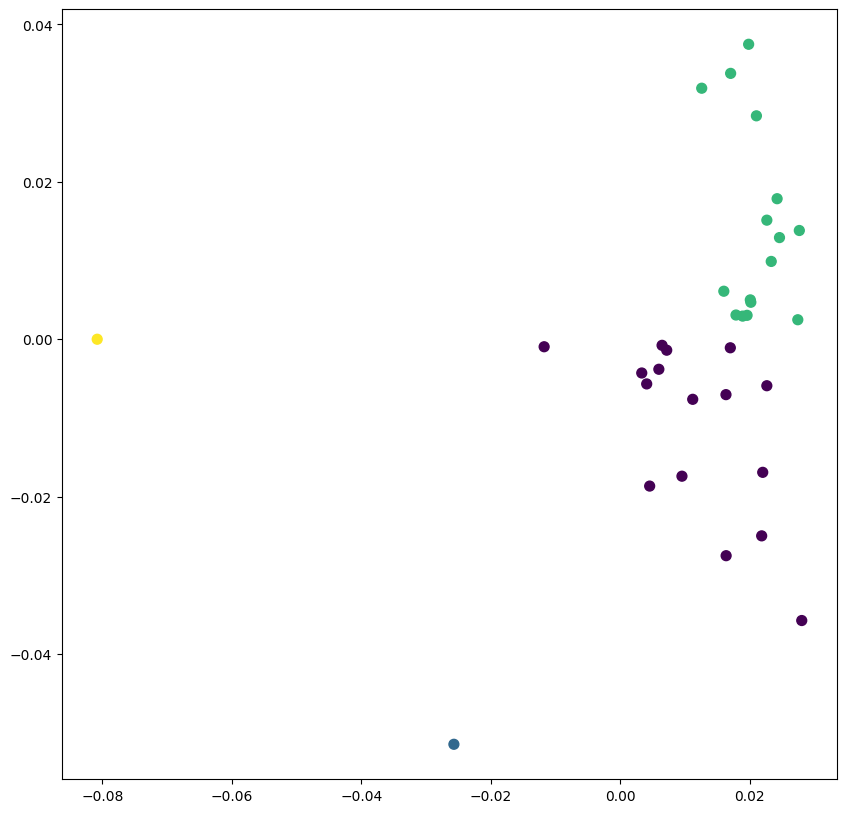

In [38]:
# plot the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(*zip(*embeddings), c=kmeans.labels_, s=50, cmap='viridis')
plt.show()